<a href="https://colab.research.google.com/github/jmestanza/Control/blob/master/VoiceLinearFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Guía 3: Laboratorio de predicción lineal
Grupo 1: 

Integrantes:


Gonzalez Orlando, Tomás Agustin

Mestanza, Joaquín Matías


###Importamos los datos  y el contenido de las librerias a utilizar

In [0]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from IPython.display import Audio
from scipy.linalg import toeplitz
import librosa    


from IPython.display import clear_output
! wget "https://raw.githubusercontent.com/taomasgonzalez/Voice-Linear-Filter/master/data/A2segs_44k1.wav"
! wget "https://raw.githubusercontent.com/taomasgonzalez/Voice-Linear-Filter/master/data/SH2segs_44k1.wav"
clear_output()

###Creamos las funciones necesarias para el desarrollo del TP

In [0]:

def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    print('Archivo leido: ', stereo_file_name, 'fs : ',fs)
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos

    
def get_autocorrelation(u):
    
    u = np.concatenate((np.array(u), np.zeros(len(u))), axis=None)
    u_f = np.fft.fft(u)
    ##Estimo rxx
    rxx = np.fft.ifft(u_f * u_f.conj()).real
    rxx = rxx[:len(u)//2]/len(u)

    return rxx

def getJplotWfandu_n(audio, size):
    J = []
    wf = []
    u_n_hat = []
    u_n = audio[-1] # nos quedamos con la ultima muestra
    u_n_minus1 = audio[:len(audio)-1] # esto es [...u(n-2),u(n-1)]
    u_n_minus1 = np.flip(u_n_minus1) # esto es [u(n-1), u(n-2),...]
    rxx = get_autocorrelation(u_n_minus1) 
    for M in range(1,size+1):
        # quiero hacer la prediccion con todo el arreglo menos la muestra
        # a estimar
        rxx_= rxx[:M] # esto toma los valores desde 0 hasta M-1 inclusive
        r = rxx[1:M+1]
        R = toeplitz(rxx_)
        wf_actual = np.linalg.solve(R, r)
        # Pm es el error cuadrático medio de predicción forward! o sea que Pm es
        # el J de la consigna
        J_actual = rxx[0]- np.matmul(r.conj().transpose(),wf_actual)
        J.append(J_actual)
        # J tiene que dar mayor que cero!!! Pm = E{|fM(n)|^2}
        u_n_hat_actual = 0
        for k in range(0,M):
            u_n_hat_actual += wf_actual[k].conjugate()*u_n_minus1[k] # [u(n-1), u(n-2),...]
        u_n_hat.append(u_n_hat_actual)
        
    return J, wf, u_n_hat, u_n


def getSquaredError(u_n_hat_k, u_n):
    error = u_n-u_n_hat_k
    return error**2


###Guardamos los audios en el diccionario sound_dict

In [4]:
# guardamos los audios
sound_dict = {'A': 'A2segs_44k1.wav', 'SH' : 'SH2segs_44k1.wav' }
sound_arrays = {}

for sound_name in sound_dict:
    sound_arr, fs = librosa.load(sound_dict[sound_name], sr=8000) # Downsample 44.1kHz to 8kHz
    print('Agregando ',sound_dict[sound_name], ' fs ', fs)
    sound_arrays[sound_name] = sound_arr # agrego al diccionario el arreglo y para llamarlo uso el nombre

Agregando  A2segs_44k1.wav  fs  8000
Agregando  SH2segs_44k1.wav  fs  8000


##Realización de la predicción forward con $N_{0}$ =1 y representación del error cuadrático medio J en función de M con entre 0 y 100

###Caso /a/

Comparamos el J con el error al cuadrado:
J (con M=  100 )= 7.840549101102836e-07   Error al cuadrado: 1.0914521877946575e-07


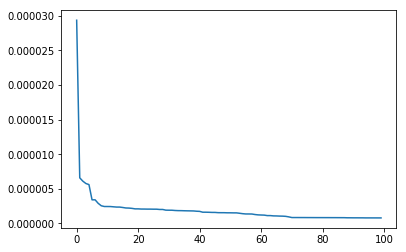

In [19]:
size = 100 
audio = sound_arrays['A']
J, wf, u_n_hat, u_n = getJplotWfandu_n(audio,size)
plt.plot(J)
u_n_hat_k = u_n_hat[-1] 
error_squared = getSquaredError(u_n_hat_k, u_n)
print('Comparamos el J con el error al cuadrado:')
print('J (con M= ',size,')=', J[-1],'  Error al cuadrado:', error_squared)



###Caso /sh/

Comparamos el J con el error al cuadrado:
J (con M=  100 )= 3.5893644564081857e-07   Error al cuadrado: 3.789078123552962e-07


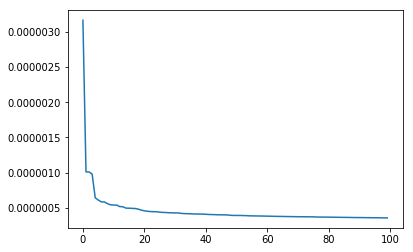

In [22]:
size = 100 
audio = sound_arrays['SH']
J, wf, u_n_hat, u_n = getJplotWfandu_n(audio,size)
plt.plot(J)
u_n_hat_k = u_n_hat[-1] 
error_squared = getSquaredError(u_n_hat_k, u_n)
print('Comparamos el J con el error al cuadrado:')
print('J (con M= ',size,')=', J[-1],'  Error al cuadrado:', error_squared)

##Algoritmo de Levinson-Durbin

In [0]:
# esto es una prueba
audio = sound_arrays['A']
M = 5
r = get_autocorrelation(audio)
r = r[:M+2] # r[0], r[1], r[M], r[M+1] agrego r[M+1] porque hay un
# caso en el cual lo necesita calcular
P = []
delta = []
k = []
a = [[0 for i in range(M+1)] for j in range(M+1)]
#a = np.zeros((M+1,M+1))

for m in range(M+1):
    for j in range(M+1):
        if j == 0:
            a[m][j]=1
            
P.append(r[0])
delta.append(r[1].conjugate())
a.append(1)
for m in range(1,M+1):
    km = -delta[m-1]/P[m-1]
    for k_index in range(1,m+1):
        a[m][k_index] = a[m-1][k_index] + km * a[m-1][m-k_index]
        
    suma = 0
    for l in range(0,m+1):
        suma += r[m+1-l]* a[m][l] 
    delta.append(suma+r[m+1]) # este es el caso en el que necesita r[M+1]
    P.append(P[m-1]*(1-km**2 ))
    